In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch
from time import time
from fvcore.nn import FlopCountAnalysis
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large

In [2]:
def load_json_metrics(file_path):
    with open(file_path, 'r') as fp:
        metrics = json.load(fp)
    return metrics

def plot_json(json_dict, name, ax):
    ax.plot(list(json_dict.keys()), list(json_dict.values()), label=name)
    
def get_mean_metric(metric_dict, from_epoch, to_epoch=None):
    df = pd.DataFrame.from_dict(metric_dict, orient='index')
    return df[from_epoch:to_epoch].mean().item()

def get_n_params(model, verbose=False):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    if verbose:
        print('Total Params: ', pytorch_total_params)

    params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            params += param.numel()
    if verbose:
        print('Trainable Params: ', params)
    return pytorch_total_params, params

### IoU Metrics

In [3]:
metric_of_interest = 'iou'

# UNet
unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/frosty_sponge_239_unet_ice-mean-{metric_of_interest}-epoch.json')

# Small UNet
small_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/laced_disco_238_small_unet_ice-mean-{metric_of_interest}-epoch.json')

# LBC UNet
lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/worthy_wood_227_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small LBC UNet
small_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/sandy_moon_228_small_lbc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
deeplab_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/vivid_donkey_305_deeplab_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Deeplab MobileNet
lraspp_mobile_net = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/clean_darkness_312_laraspp_mobilenet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC UNet
dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/helpful_fire_308_unet_dsc_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small DSC UNet
small_dsc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/cosmic_waterfall_315_small_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# DSC LBC UNet
dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/youthful_microwave_310_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')

# Small DSC LBC UNet
small_dsc_lbc_unet = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/val_set/still_paper_311_small_lbc_dsc_unet_ice-mean-{metric_of_interest}-epoch-128-256-size.json')


metric_dicts = {
    'unet': unet, 
    'small_unet': small_unet,
    'lbc_unet': lbc_unet, 
    'small_lbc_unet': small_lbc_unet,
    'deeplab_mobile_net': deeplab_mobile_net,
    'lraspp_mobile_net': lraspp_mobile_net,
    'dsc_unet': dsc_unet,
    'small_dsc_unet': small_dsc_unet,
    'dsc_lbc_unet': dsc_lbc_unet,
    'small_dsc_lbc_unet': small_dsc_lbc_unet,
}

In [16]:
unet_tmp = load_json_metrics(f'/home/dsola/repos/PGA-Net/results/tmp/frosty_sponge_239_unet_ice-mean-{metric_of_interest}-epoch.json')

In [17]:
unet_tmp['1']

0.5276278257369995

In [10]:
unet['1']

0.5927869081497192

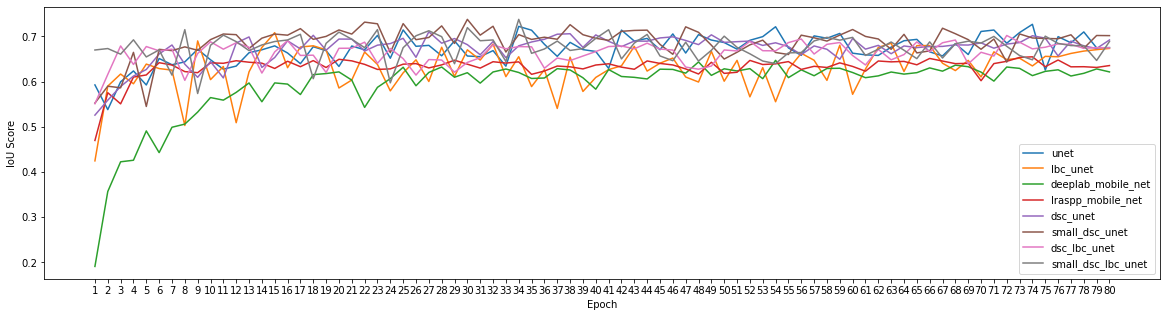

In [31]:
fig, ax = plt.subplots(figsize=(20,5))

ax.set_ylabel('IoU Score')
ax.set_xlabel('Epoch')
plot_json(unet, 'unet', ax)
plot_json(lbc_unet, 'lbc_unet', ax)
plot_json(deeplab_mobile_net, 'deeplab_mobile_net', ax)
plot_json(lraspp_mobile_net, 'lraspp_mobile_net', ax)
plot_json(dsc_unet, 'dsc_unet', ax)
plot_json(small_dsc_unet, 'small_dsc_unet', ax)
plot_json(dsc_lbc_unet, 'dsc_lbc_unet', ax)
plot_json(small_dsc_lbc_unet, 'small_dsc_lbc_unet', ax)
plt.legend();
# ax.set_title('Full Size Comparison');

In [32]:
FROM_EPOCH = 20
avg_metric_dict = {}
for model in metric_dicts.keys():
    avg_metric_dict[model] = get_mean_metric(metric_dicts[model], FROM_EPOCH)

In [33]:
avg_metric_dict

{'unet': 0.682293904821078,
 'small_unet': 0.7044796794652939,
 'lbc_unet': 0.6352974305550257,
 'small_lbc_unet': 0.6416343748569489,
 'deeplab_mobile_net': 0.6175214439630509,
 'lraspp_mobile_net': 0.6361964911222457,
 'dsc_unet': 0.6831983198722203,
 'small_dsc_unet': 0.6951989223559697,
 'dsc_lbc_unet': 0.6656334926684697,
 'small_dsc_lbc_unet': 0.677533096075058}

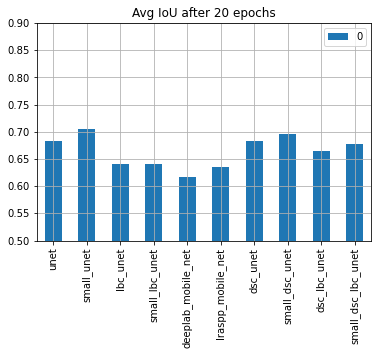

In [21]:
ax = pd.DataFrame.from_dict(avg_metric_dict, orient='index').plot.bar(ylim=(0.5, 0.90), title='Avg IoU after 20 epochs')
ax.grid();

In [ ]:
pd.DataFrame.from_dict(avg_metric_dict, orient='index')

### Model Parameters

In [14]:
unet_model = UNet(n_channels=3, n_classes=3, bilinear=True)
small_unet_model = SmallUNet(n_channels=3, n_classes=3, bilinear=True)
# axial_unet_model = AxialUNet(3, 3, 64)
lbc_unet_model = UNetLBP(3, 3)
small_lbc_unet_model = SmallUNetLBP(3, 3)
small_axial_lbc_unet_model = SmallAxialUNetLBC(3, 3, 10)
deeplab_mobile_net_model = deeplabv3_mobilenet_v3_large(num_classes=3)
lraspp_mobile_net_model = lraspp_mobilenet_v3_large(num_classes=3)
dsc_unet_model = UNetDSC(n_channels=3, n_classes=3, bilinear=True)
small_dsc_unet_model = SmallUNetDSC(n_channels=3, n_classes=3, bilinear=True)
dsc_lbc_unet_model = DSCUNetLBP(3, 3)
# small_dsc_lbc_unet_model = DSCSmallUNetLBP(3, 3)

models_dict = {
    'unet': unet_model,
#     'axial_unet': axial_unet_model,
#     'small_unet': small_unet_model,
    'lbc_unet': lbc_unet_model,
#     'small_lbc_unet': small_lbc_unet_model,
#     'small_axial_lbc_unet': small_axial_lbc_unet_model,
    'deeplab_mobile_net': deeplab_mobile_net_model,
    'lraspp_mobile_net': lraspp_mobile_net_model,
    'dsc_unet': dsc_unet_model,
#     'small_dsc_unet': small_dsc_unet_model,
    'dsc_lbc_unet': dsc_lbc_unet_model,
#     'small_dsc_lbc_unet': small_dsc_lbc_unet_model,
}

In [15]:
model_tot_param_dict, model_train_param_dict = {}, {}
for model in models_dict.keys():
#     print(model, ': ')
    tot, train = get_n_params(models_dict[model])
    model_tot_param_dict[model] = tot
    model_train_param_dict[model] = train

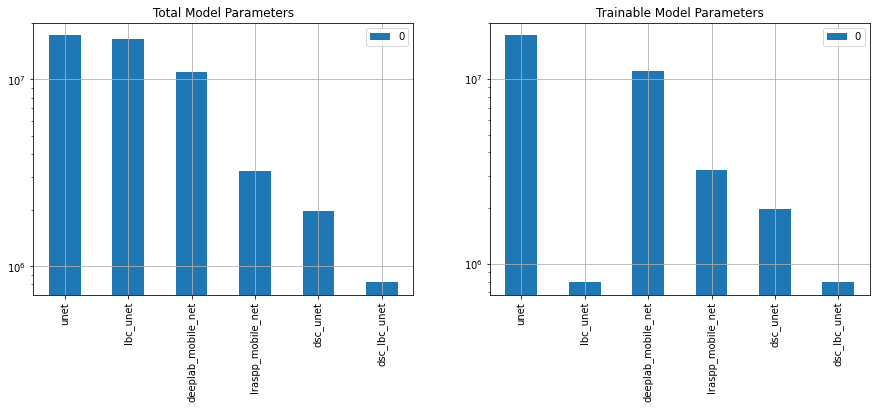

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(model_tot_param_dict, orient='index').plot.bar(ax=axs[0], title='Total Model Parameters', logy=True)
pd.DataFrame.from_dict(model_train_param_dict, orient='index').plot.bar(ax=axs[1], title='Trainable Model Parameters', logy=True)
axs[0].grid()
axs[1].grid();

In [17]:
pd.DataFrame.from_dict(model_tot_param_dict, orient='index')

,0
unet,17267523
lbc_unet,16498842
deeplab_mobile_net,11020851
lraspp_mobile_net,3218478
dsc_unet,1983713
dsc_lbc_unet,821220


In [18]:
pd.DataFrame.from_dict(model_train_param_dict, orient='index')

,0
unet,17267523
lbc_unet,794697
deeplab_mobile_net,11020851
lraspp_mobile_net,3218478
dsc_unet,1983713
dsc_lbc_unet,794697


### FLOPs

In [19]:
device = 'cpu'
inp = torch.rand(2,3,320,320).to(device)

model_flop_dict = {}
for model in models_dict.keys():
    flops = FlopCountAnalysis(models_dict[model].to(device), inp)
    model_flop_dict[model] = flops.total()/1000000

Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::sub encountered 16 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::max_pool2d encountered 4 time(s)
Unsupported operator aten::sub encountered 16 time(s)
Unsupported operator aten::hardswish_ encountered 20 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::hardsigmoid_ encountered 8 time(s)
Unsupported operator aten::mul encountered 8 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.

Unsupported operator aten::hardswish_ encountered 20 time(s)
Unsupported operator aten::add_ encountered 10 time(s)
Unsupported operator aten::hardsigmoid_ encount

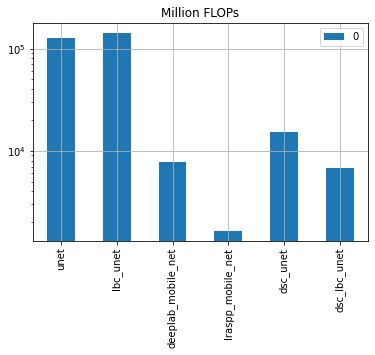

In [20]:
ax = pd.DataFrame.from_dict(model_flop_dict, orient='index').plot.bar(title='Million FLOPs', logy=True)
ax.grid();

In [21]:
pd.DataFrame.from_dict(model_flop_dict, orient='index')

,0
unet,125529.29280
lbc_unet,142096.38400
deeplab_mobile_net,7796.82048
lraspp_mobile_net,1652.03456
dsc_unet,15434.34240
dsc_lbc_unet,6805.50400


### Run Time

In [ ]:
cuda_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cuda_v3.json')
cpu_dict = load_json_metrics(f'/home/dsola/repos/PGA-Net/src/train/model_profile_cpu_v3.json')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(cuda_dict, orient='index').plot.bar(ax=axs[0], title='Train 3 Epochs on GPU')
pd.DataFrame.from_dict(cpu_dict, orient='index').plot.bar(ax=axs[1], title='Train 3 Epochs on CPU')
axs[0].grid()
axs[1].grid();

In [4]:
def net_time_test(net, times, input_, mobile=False):
    backprop_duration = 0
    inference_duration = 0
    for i in range(times):
        if mobile:
            inference_start = time()
            out = net(input_)['out']
            inference_end = time()
        else:
            inference_start = time()
            out = net(input_)
            inference_end = time()
        backprop_start = time()
        out.backward(gradient=torch.randn(2, 3, 256, 256).to(device=device))
        backprop_end = time()
        backprop_duration += backprop_end - backprop_start
        inference_duration += inference_end - inference_start
    return backprop_duration, inference_duration

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


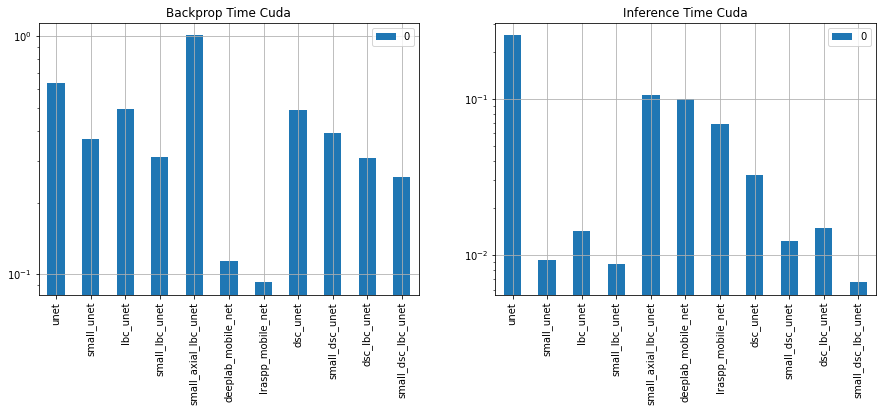

In [5]:
device = 'cuda'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=False)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time Cuda', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time Cuda', logy=True)
axs[0].grid()
axs[1].grid();

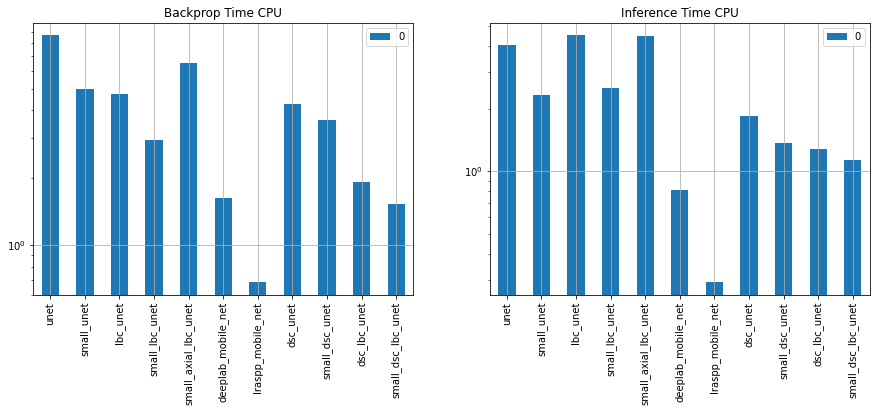

In [6]:
device = 'cpu'
iterations = 5
backprop_dict, inference_dict = {}, {}
input_ = torch.randn(2, 3, 256, 256).to(device=device)
for model in models_dict.keys():
    if 'mobile' in model:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_, mobile=True)
    else:
        backprop_time, inference_time = net_time_test(models_dict[model].to(device), iterations, input_)
    backprop_dict[model] = backprop_time
    inference_dict[model] = inference_time

fig, axs = plt.subplots(1,2, figsize=(15,5))
pd.DataFrame.from_dict(backprop_dict, orient='index').plot.bar(ax=axs[0], title='Backprop Time CPU', logy=True)
pd.DataFrame.from_dict(inference_dict, orient='index').plot.bar(ax=axs[1], title='Inference Time CPU', logy=True)
axs[0].grid()
axs[1].grid();

In [5]:
from torchvision import models
from torchsummary import summary
from src.models.lbcnn.axial_lbcnn import SmallAxialUNetLBC, AxialUNetLBC
from src.models.lbcnn.axial_unet import AxialUNet, SmallAxialUNet
from src.models.lbcnn.lbc_unet import UNetLBP, SmallUNetLBP
from src.models.unet.unet_model import UNet, SmallUNet
from src.models.dsc.dsc_lbc_unet import DSCSmallUNetLBP, DSCUNetLBP
from src.models.dsc.dsc_unet import UNetDSC, SmallUNetDSC
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, lraspp_mobilenet_v3_large

In [10]:
summary(UNetDSC(3, 3), (3, 256, 256), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              30
            Conv2d-2         [-1, 64, 256, 256]             256
         Conv2dDSC-3         [-1, 64, 256, 256]               0
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]             640
            Conv2d-7         [-1, 64, 256, 256]           4,160
         Conv2dDSC-8         [-1, 64, 256, 256]               0
       BatchNorm2d-9         [-1, 64, 256, 256]             128
             ReLU-10         [-1, 64, 256, 256]               0
    DoubleConvDSC-11         [-1, 64, 256, 256]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]             640
           Conv2d-14        [-1, 128, 1

In [11]:
summary(UNetDSC(3, 3).to('cuda'), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 256, 256]              30
            Conv2d-2         [-1, 64, 256, 256]             256
         Conv2dDSC-3         [-1, 64, 256, 256]               0
       BatchNorm2d-4         [-1, 64, 256, 256]             128
              ReLU-5         [-1, 64, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]             640
            Conv2d-7         [-1, 64, 256, 256]           4,160
         Conv2dDSC-8         [-1, 64, 256, 256]               0
       BatchNorm2d-9         [-1, 64, 256, 256]             128
             ReLU-10         [-1, 64, 256, 256]               0
    DoubleConvDSC-11         [-1, 64, 256, 256]               0
        MaxPool2d-12         [-1, 64, 128, 128]               0
           Conv2d-13         [-1, 64, 128, 128]             640
           Conv2d-14        [-1, 128, 1

In [11]:
summary(dsc_lbc_unet_model.to('cuda'), (3, 320, 320))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 3, 320, 320]               6
        DSCConvLBP-2          [-1, 3, 320, 320]              27
            Conv2d-3         [-1, 64, 320, 320]             256
DSCDSCBlockLBPUNet-4         [-1, 64, 320, 320]               0
         MaxPool2d-5         [-1, 64, 160, 160]               0
       BatchNorm2d-6         [-1, 64, 160, 160]             128
        DSCConvLBP-7         [-1, 64, 160, 160]             576
            Conv2d-8        [-1, 128, 160, 160]           8,320
DSCDSCBlockLBPUNet-9        [-1, 128, 160, 160]               0
       DSCDownLBP-10        [-1, 128, 160, 160]               0
        MaxPool2d-11          [-1, 128, 80, 80]               0
      BatchNorm2d-12          [-1, 128, 80, 80]             256
       DSCConvLBP-13          [-1, 128, 80, 80]           1,152
           Conv2d-14          [-1, 256,

In [3]:
deeplab_mobile_net_model

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 